cuda:0


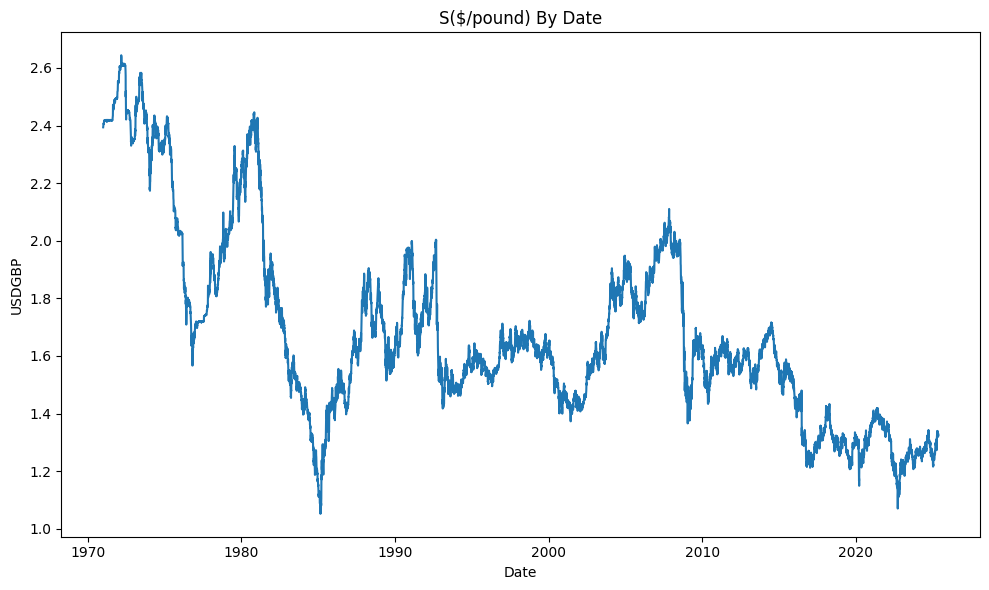

In [1]:
from docs.doc import fred_api_key
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler



device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






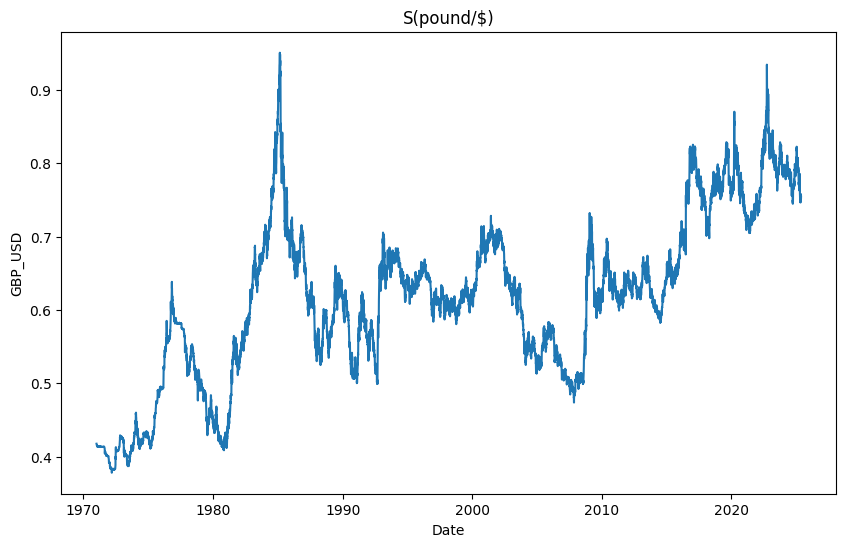

In [2]:
""" Example of S(pound/USD)"""

df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:

""" there is no Arbitrage in the FX market
 1 / USDGBP == GBPUSD; 1 / GBPUSD == USDGBP"""

GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3303     0.75171014]
  [0.75171014 1.3303    ]]

 [[1.3292     0.75233223]
  [0.75233223 1.3292    ]]

 [[1.3257     0.75431847]
  [0.75431847 1.3257    ]]]


In [4]:


df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn = nn.MSELoss()
epochs = 100



for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_14864\1147971705.py:80: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_14864\1147971705.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.35; Test RSME: 0.04506
Epoch: 1; train_RSEM: 0.2393; Test RSME: 0.1085
Epoch: 2; train_RSEM: 0.1722; Test RSME: 0.2572
Epoch: 3; train_RSEM: 0.24; Test RSME: 0.3996
Epoch: 4; train_RSEM: 0.2586; Test RSME: 0.4199
Epoch: 5; train_RSEM: 0.2126; Test RSME: 0.3606
Epoch: 6; train_RSEM: 0.1657; Test RSME: 0.2698
Epoch: 7; train_RSEM: 0.1707; Test RSME: 0.1803
Epoch: 8; train_RSEM: 0.2013; Test RSME: 0.1193
Epoch: 9; train_RSEM: 0.21; Test RSME: 0.09933
Epoch: 10; train_RSEM: 0.1909; Test RSME: 0.1139
Epoch: 11; train_RSEM: 0.1588; Test RSME: 0.1522
Epoch: 12; train_RSEM: 0.1382; Test RSME: 0.2019
Epoch: 13; train_RSEM: 0.145; Test RSME: 0.248
Epoch: 14; train_RSEM: 0.1612; Test RSME: 0.2757
Epoch: 15; train_RSEM: 0.163; Test RSME: 0.2762
Epoch: 16; train_RSEM: 0.1462; Test RSME: 0.2514
Epoch: 17; train_RSEM: 0.1229; Test RSME: 0.2102
Epoch: 18; train_RSEM: 0.1107; Test RSME: 0.164
Epoch: 19; train_RSEM: 0.1152; Test RSME: 0.1232
Epoch: 20; train_RSEM: 0.1231; Test RS

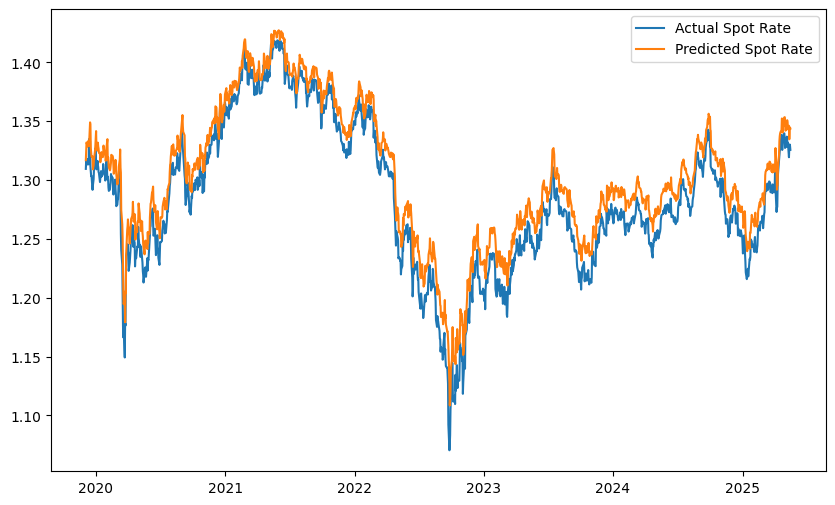

In [5]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()


In [6]:
print(np.round(comparison_df,2).head(20))
print(np.round(comparison_df,2).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12273 2019-12-04              1.31                 1.32
12274 2019-12-05              1.32                 1.33
12275 2019-12-06              1.31                 1.33
12276 2019-12-09              1.32                 1.33
12277 2019-12-10              1.32                 1.33
12278 2019-12-11              1.32                 1.33
12279 2019-12-12              1.31                 1.33
12280 2019-12-13              1.33                 1.33
12281 2019-12-16              1.33                 1.35
12282 2019-12-17              1.31                 1.35
12283 2019-12-18              1.31                 1.33
12284 2019-12-19              1.30                 1.32
12285 2019-12-20              1.30                 1.32
12286 2019-12-23              1.29                 1.32
12287 2019-12-24              1.30                 1.31
12288 2019-12-26              1.30                 1.31
12289 2019-12-27              1.31              